# Training a ML model
> Make sure that you have sucessfully executed the script `Step_01_DataPreprocessing` and the pickle fileshave been created and they are located inside the `data/` folder relative to this file.

The preprocessed pickle files will be loaded and split into a training and a validation set. We will then train a sequential model with the capacitive image matrices as input values and the weight values as excpected ouput values. The model and a log of the training process will be saved to the folder `ModelSnapshots/`.

In [1]:
import numpy as np
import time
from datetime import timedelta
import math

import datetime
import time

import tensorflow as tf

import pandas as pd
import numpy as np
import keras as keras
keras.backend.set_image_data_format('channels_last')

import keras.backend as K

from keras.models import Sequential

from keras.layers.convolutional import Conv2D

from keras.layers import Dense, Activation, Flatten, Dropout, MaxPool2D, BatchNormalization
from keras.models import Model
from keras import optimizers

from keras.callbacks import CSVLogger, ReduceLROnPlateau, ModelCheckpoint

import matplotlib.pyplot as plt

import random

Using TensorFlow backend.


In [2]:
DATA_PATH = 'data/'

In [3]:
MODEL_PATH = 'model/'

In [6]:
df = pd.read_pickle(DATA_PATH + "data.pkl")
df.Weight = df.Weight.astype(np.float)
df.BlobImages = df.BlobImages.apply(lambda x : x.reshape(27, 15, 1))

df_train = df[df.Set == "Train"]
df_test = df[(df.Set == "Test") & (df.Noise == 0) & (df.Version == "Normal")]

# Training set        
train_x = df_train.BlobImages.values
print("Training data set %i" % len(train_x))
train_y = df_train.Weight.values

# Test set        
test_x = df_test.BlobImages.values
print("Test data set %i" % len(test_x))
test_y = df_test.Weight.values

test_y = test_y.astype('float32')
train_y = train_y.astype('float32')

train_x = np.concatenate(train_x).reshape(-1, 27, 15, 1) / 255.0
test_x = np.concatenate(test_x).reshape(-1, 27, 15, 1) / 255.0

test_x = test_x.astype('float32')
train_x = train_x.astype('float32')

#del df
#del df_train
#del df_test
print("Done!")

Training data set 888460
Test data set 16781
Done!


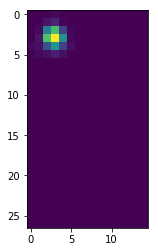

In [7]:
plt.imshow(train_x[0].reshape(27,15))

In [ ]:
with tf.device('/gpu:1'):    
    # regulate gpu usage
    config = tf.ConfigProto(log_device_placement=True, allow_soft_placement=True)#, device_count = {'GPU' : 4})
    config.gpu_options.allow_growth=True
    config.gpu_options.per_process_gpu_memory_fraction=0.3
    config.gpu_options.allocator_type = 'BFC'
    with tf.Session(config=config):
        model = Sequential()
        MODEL_NAME_PREFIX = "model"

        # First layer of convolution and max pooling
        model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu', input_shape = (27,15,1)))
        model.add(BatchNormalization(axis=-1))
        model.add(Dropout(0.5))
        
        model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                         activation ='relu'))
        model.add(BatchNormalization(axis=-1)) 
        model.add(MaxPool2D(pool_size=(2,2)))
        model.add(Dropout(0.5))


        model.add(Conv2D(filters = 48, kernel_size = (3,3),padding = 'Same', 
                         activation ='relu'))        
        model.add(BatchNormalization(axis=-1))
        model.add(MaxPool2D(pool_size=(2,2)))
        model.add(Dropout(0.5))

        model.add(Flatten())
        model.add(Dense(128, kernel_regularizer=keras.regularizers.L1L2(0.02, 0.15)))
        model.add(keras.layers.advanced_activations.LeakyReLU())
        #model.add(keras.layers.ReLU())
        model.add(Dropout(0.5))
        model.add(Dense(64, kernel_regularizer=keras.regularizers.L1L2(0.02, 0.15)))
                        #activity_regularizer=keras.regularizers.l2(0.001)))
        #model.add(keras.layers.ReLU())
        model.add(keras.layers.advanced_activations.LeakyReLU())
        model.add(Dropout(0.5))
        model.add(Dense(1))

        learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                                    patience=10, 
                                                    verbose=1, 
                                                    factor=0.9, 
                                                    min_lr=0.00001)
        def rmse(y_true, y_pred):
                return K.sqrt(K.mean(K.square(y_pred - y_true))) 

        #RMSprop optimizer
        optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
        model.compile(loss='mse', optimizer=optimizer, metrics=['mae', rmse])


        readable_timestamp = datetime.datetime.fromtimestamp(time.time()).strftime('%Y%m%d_%H%M%S')
        outFile = MODEL_NAME_PREFIX + 
        print (outFile)
        csv_logger = CSVLogger(MODEL_PATH + '/' + outFile)
        tensorflowFolder = "/srv/share/tensorboardfiles/" + outFile
        tfbCallback = keras.callbacks.TensorBoard(log_dir=tensorflowFolder, histogram_freq=0,  
                  write_graph=True, write_images=True)

        checkpointCallback = ModelCheckpoint("./ModelSnapshots/" + outFile + '-{epoch:03d}.h5',
                                             verbose=1, monitor='val_loss', save_best_only=True, mode='auto')  

        model.summary()

        # Train data
        model.fit(train_x, train_y,
                           batch_size=500,
                           epochs=500,
                           verbose=1,
                           validation_data=(test_x, test_y),
                           callbacks=[learning_rate_reduction, csv_logger, tfbCallback, checkpointCallback])
        
        model.save("./ModelSnapshots/" + outFile + '-500.h5')

model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 27, 15, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 27, 15, 32)        128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 27, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 27, 15, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 27, 15, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 7, 32)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 13, 7, 32)         0         
____